## Tensorflow 2.x text based cnn and lstm learning
- Set of bbc news articles divided into 5 categories(sport, business, politics, tech, entertainment)
- Task to identify which article belongs to which category

## Import libraries

In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


- nltk is used for stopwords.
- we have to initialize nltk by nltk.download('stopwords')

In [3]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
import matplotlib.pyplot as plt

In [4]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

## Loading dataset

In [5]:
articles = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


## Test Train spliting (80/20 split)

In [6]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

1780
1780
1780
445
445


## Tokenizing 

Model can't understand words so we convert them to numbers which model can understand 

In [7]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [8]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(train_sequences))
print(train_padded.shape)

1780
(1780, 200)


In [9]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 200)


In [10]:
print(set(labels))

{'sport', 'tech', 'politics', 'business', 'entertainment'}


In [11]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

print(label_tokenizer.word_index)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))


{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}


0 is saved for padding

We therefore have 6 classes. Padding plus above 5

## Function to plot graphs

In [12]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## CNN Model

In [13]:
cnnmodel = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                             input_length=max_length),
    # specify the number of convolutions that you want to learn, their size, and their activation function.
    # words will be grouped into the size of the filter in this case 5
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
cnnmodel.summary()

# alternate method to make sequential model
# cnnmodel = tf.keras.Sequential()
# cnnmodel.add(tf.keras.layers.Conv1D(128, 5, activation='relu'))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 64)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          41088     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 369,734
Trainable params: 369,734
Non-trainable params: 0
_________________________________________________________________


In [14]:
cnnmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
cnnhistory = cnnmodel.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 - 2s - loss: 1.5325 - accuracy: 0.3876 - val_loss: 1.0938 - val_accuracy: 0.6427
Epoch 2/10
1780/1780 - 1s - loss: 0.5541 - accuracy: 0.8747 - val_loss: 0.2455 - val_accuracy: 0.9551
Epoch 3/10
1780/1780 - 1s - loss: 0.0925 - accuracy: 0.9865 - val_loss: 0.1316 - val_accuracy: 0.9730
Epoch 4/10
1780/1780 - 1s - loss: 0.0286 - accuracy: 0.9978 - val_loss: 0.1127 - val_accuracy: 0.9708
Epoch 5/10
1780/1780 - 1s - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.1047 - val_accuracy: 0.9685
Epoch 6/10
1780/1780 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.1070 - val_accuracy: 0.9685
Epoch 7/10
1780/1780 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.1058 - val_accuracy: 0.9663
Epoch 8/10
1780/1780 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.1024 - val_accuracy: 0.9663
Epoch 9/10
1780/1780 - 1s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1048 - val_accuracy: 0.9663
Epoch 10/10
1780/1780 - 1s - loss: 

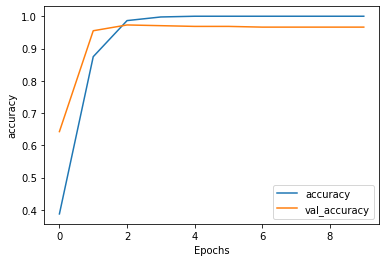

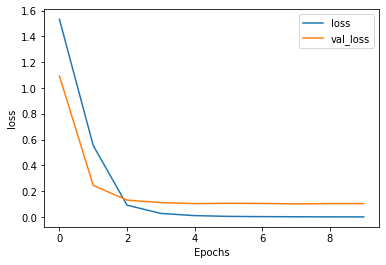

In [15]:
plot_graphs(cnnhistory, "accuracy")
plot_graphs(cnnhistory, "loss")

## LSTM (RNN) Model

In [16]:
rnnmodel = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
rnnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


In [17]:
rnnmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
rnnhistory = rnnmodel.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 - 4s - loss: 1.5806 - accuracy: 0.3028 - val_loss: 1.3770 - val_accuracy: 0.3708
Epoch 2/10
1780/1780 - 1s - loss: 1.3181 - accuracy: 0.4399 - val_loss: 1.0024 - val_accuracy: 0.6607
Epoch 3/10
1780/1780 - 1s - loss: 0.5010 - accuracy: 0.8579 - val_loss: 0.3653 - val_accuracy: 0.8899
Epoch 4/10
1780/1780 - 1s - loss: 0.1812 - accuracy: 0.9427 - val_loss: 0.2908 - val_accuracy: 0.9079
Epoch 5/10
1780/1780 - 1s - loss: 0.0808 - accuracy: 0.9753 - val_loss: 0.2183 - val_accuracy: 0.9348
Epoch 6/10
1780/1780 - 1s - loss: 0.0283 - accuracy: 0.9921 - val_loss: 0.2272 - val_accuracy: 0.9258
Epoch 7/10
1780/1780 - 1s - loss: 0.0482 - accuracy: 0.9882 - val_loss: 0.2900 - val_accuracy: 0.9124
Epoch 8/10
1780/1780 - 1s - loss: 0.0242 - accuracy: 0.9944 - val_loss: 0.2020 - val_accuracy: 0.9483
Epoch 9/10
1780/1780 - 1s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.2088 - val_accuracy: 0.9438
Epoch 10/10
1780/1780 - 1s - loss: 

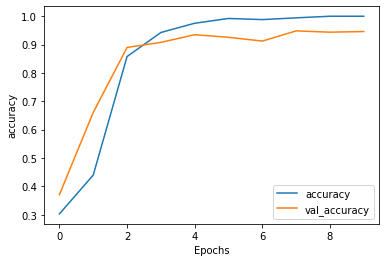

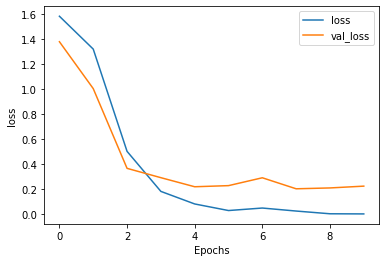

In [18]:
plot_graphs(rnnhistory, "accuracy")
plot_graphs(rnnhistory, "loss")